# Load Data

In [1]:
# !pip install tensorflow
# !pip uninstall -y keras
# !pip install tf-keras
# !pip install rouge_score
# !pip install transformers
# !pip install torch
# !pip install nltk
# !pip install torchinfo
# !pip install pydot
# !pip install graphviz
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Embedding, Dense, Dropout, Bidirectional, Concatenate, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BartTokenizer
import torch
# from sentence_transformers import SentenceTransformer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from tensorflow.keras.models import load_model
from tqdm import tqdm
import json

2025-05-26 21:06:53.827035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748293613.847997   38362 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748293613.854531   38362 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748293613.871278   38362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748293613.871297   38362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748293613.871300   38362 computation_placer.cc:177] computation placer alr

In [2]:
import os
# Force TF to allow memory growth on GPUs
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# Now configure in code (optional—you can skip this if the env var works)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} GPU(s) configured for memory growth.")
else:
    print("No GPU detected.")

1 GPU(s) configured for memory growth.


In [3]:
# # %%
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive/')

# Load your data
df = pd.read_csv("valid.csv")
df_test = pd.read_csv("test-curated.csv")


SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# import os
# save_dir = '/content/drive/MyDrive/Machine Learning II'
# os.makedirs(save_dir, exist_ok=True)

In [4]:
pd.set_option("display.max_colwidth", 500)
df.head()

,desc,output,type,company,industry,url,alias,desc_masked,output_masked,ent_dict,unsupported,first_pos
0,"The latest <company> & Point of Sale tech for the lowest prices. Flexible monthly rental options with the backing of our dedicated, on-call support team.",Taking Care of Small Business Technology,headline_long,eftpos warehouse,computer hardware,eftposwarehouse.co.nz,Eftpos Warehouse,"The latest <company> & Point of Sale tech for the lowest prices. Flexible [date] rental options with the backing of our dedicated, on-call support team.",Taking Care of Small Business Technology,{'[date]': 'monthly'},False,VB
1,Easily deliver personalized activities that enrich the lives of residents in older adult communities. Save time and increase satisfaction.,Build World-Class Recreation Programs,headline,welbi,"health, wellness and fitness",welbi.co,Welbi,Easily deliver personalized activities that enrich the lives of residents in older adult communities. Save time and increase satisfaction.,Build World-Class Recreation Programs,{},False,VB
2,Powerful lead generation software that converts abandoning visitors into subscribers with our dynamic marketing tools and Exit Intent® technology.,Most Powerful Lead Generation Software for Marketers,headline_long,optinmonster,internet,optinmonster.com,Optinmonster,Powerful lead generation software that converts abandoning visitors into subscribers with our dynamic marketing tools and Exit Intent® technology.,Most Powerful Lead Generation Software for Marketers,{},False,JJ
3,"Twine matches companies to the best digital and creative freelancers from a network of over 260,000. It's free to post a job and you only pay when you hire.",Hire quality freelancers for your job,headline_long,twine.fm,internet,twine.fm,NaN,Twine matches companies to the best digital and creative freelancers from a network of [number]. It's free to post a job and you only pay when you hire.,Hire quality freelancers for your job,"{'[number]': 'over 260,000'}",False,VB
4,"Financial Advisers Norwich, Norfolk - <company> Norwich are committed to helping you with your financial needs.","Financial Advisers Norwich, Norfolk",headline,mcb financial services ltd,financial services,mcbfinancialservices.co.uk,Mcb Financial Services,"Financial Advisers [country], [country1] - <company> [country] are committed to helping you with your financial needs.","Financial Advisers [country], [country1]","{'[country]': 'Norwich', '[country1]': 'Norfolk'}",False,NN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5346 entries, 0 to 5345
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   desc           5346 non-null   object
 1   output         5346 non-null   object
 2   type           5346 non-null   object
 3   company        5346 non-null   object
 4   industry       5346 non-null   object
 5   url            5346 non-null   object
 6   alias          4017 non-null   object
 7   desc_masked    5346 non-null   object
 8   output_masked  5346 non-null   object
 9   ent_dict       5346 non-null   object
 10  unsupported    5346 non-null   bool  
 11  first_pos      5346 non-null   object
dtypes: bool(1), object(11)
memory usage: 464.8+ KB


# EDA

In [6]:
# number of companies per industry
industry = df.groupby('industry')['output'].count().reset_index().sort_values(by = 'output', ascending = False).head(10)
industry['%_count'] = industry['output'] / industry['output'].sum() * 100
industry

,industry,output,%_count
61,information technology and services,452,21.920466
80,marketing and advertising,267,12.948594
23,computer software,257,12.463628
24,construction,195,9.456838
65,internet,187,9.068865
41,financial services,161,7.807953
114,real estate,161,7.807953
7,automotive,157,7.613967
52,"health, wellness and fitness",114,5.528613
70,law practice,111,5.383123


/var/tmp/ipykernel_38362/2105412124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


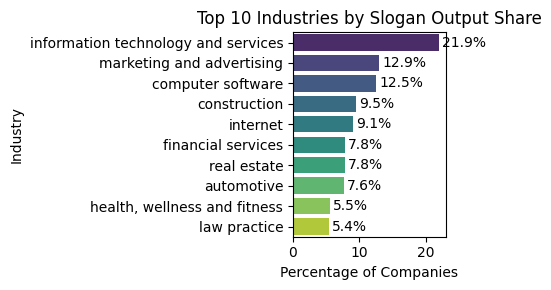

In [7]:
plt.figure(figsize=(5, 3))
ax = sns.barplot(
    data=industry,
    x='%_count',
    y='industry',
    orient='h',
    palette='viridis'
)

# Add % labels to the bars
for i, value in enumerate(industry['%_count']):
    plt.text(
        value + 0.5,                         # x position (a bit after the bar)
        i,                                   # y position (row index)
        f'{value:.1f}%',                     # label text
        va='center'
    )

plt.title('Top 10 Industries by Slogan Output Share')
plt.xlabel('Percentage of Companies')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()

Max length: 541
90th percentile: 56
95th percentile: 67
99th percentile: 91
Median: 34


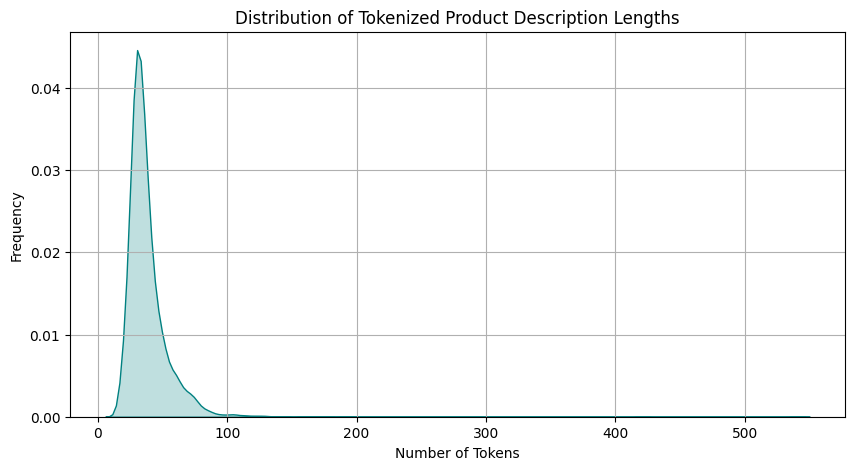

In [8]:
# Load tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Convert your input texts to lowercase strings
input_texts = df["desc_masked"].astype(str).str.lower().tolist()
target_texts = df['output_masked'].astype(str).str.lower().tolist()

# Tokenize without padding or truncation to get actual token lengths
tokenized_input = tokenizer(input_texts, padding=False, truncation=False)
tokenized_target = tokenizer(target_texts, padding=False, truncation=False)


# Get lengths of tokenized input sequences
token_input_lengths = [len(seq) for seq in tokenized_input["input_ids"]]
token_target_lengths = [len(seq) for seq in tokenized_target["input_ids"]]

# Print basic stats
print("Max length:", max(token_input_lengths))
print("90th percentile:", int(np.percentile(token_input_lengths, 90)))
print("95th percentile:", int(np.percentile(token_input_lengths, 95)))
print("99th percentile:", int(np.percentile(token_input_lengths, 99)))
print("Median:", int(np.median(token_input_lengths)))

# Plot distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(token_input_lengths, fill=True, color='teal')
plt.title("Distribution of Tokenized Product Description Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Max length: 31
90th percentile: 15
95th percentile: 17
99th percentile: 21
Median: 9


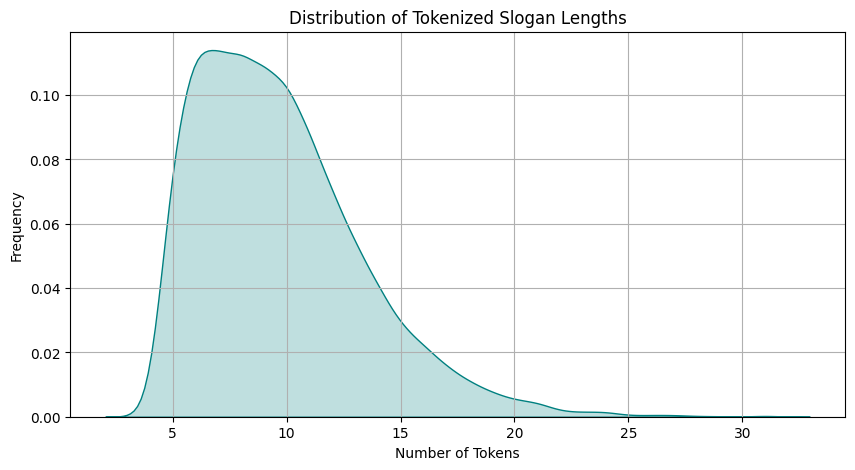

In [9]:
# Print basic stats
print("Max length:", max(token_target_lengths))
print("90th percentile:", int(np.percentile(token_target_lengths, 90)))
print("95th percentile:", int(np.percentile(token_target_lengths, 95)))
print("99th percentile:", int(np.percentile(token_target_lengths, 99)))
print("Median:", int(np.median(token_target_lengths)))

# Plot distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(token_target_lengths, fill=True, color='teal')
plt.title("Distribution of Tokenized Slogan Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Data Preprocessing

2. Extracting and formatting text
3. Tokenizing words into sequences
4. Padding sequences to equal length
5. Preparing inputs/targets for training

In [10]:
import re

DESC_COL = 'desc'
SLOGAN_COL = 'output'
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s.,?!']", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

for df in [df, df_test]:
    df[DESC_COL + '_cleaned'] = df[DESC_COL].apply(clean_text)
    df[SLOGAN_COL + '_cleaned'] = df[SLOGAN_COL].apply(clean_text)

In [11]:
df_test.head()

,desc,output,type,company,industry,url,alias,desc_masked,output_masked,ent_dict,unsupported,first_pos,desc_cleaned,output_cleaned
0,"Our expert team of Analytical Chemists provide eLiquid analysis & manufacturing services, ensuring full regulatory compliance for the e-cigarette market.",E-Liquid Testing UK,headline,el-science,chemicals,elscience.co.uk,NaN,"Our expert team of Analytical Chemists provide eLiquid analysis & manufacturing services, ensuring full regulatory compliance for the e-cigarette market.",E-Liquid Testing [u:country],{'[u:country]': 'UK'},True,JJ,"our expert team of analytical chemists provide eliquid analysis manufacturing services, ensuring full regulatory compliance for the ecigarette market.",eliquid testing uk
1,"<company> is West Michigan's full service backline rental, audio, and production resource, equipped to serve the Midwest and beyond. (616) 735-9049",Great Performances Start With Great Service,headline_long,on stage services inc.,events services,onstageservices.com,On Stage Services,"<company> is [country] full service backline rental, audio, and production resource, equipped to serve the [location] and beyond. (616) 735-9049",Great Performances Start With Great Service,"{'[country]': ""West Michigan's"", '[location]': 'Midwest'}",False,JJ,"company is west michigan's full service backline rental, audio, and production resource, equipped to serve the midwest and beyond. 616 7359049",great performances start with great service
2,"From placing entire software engineering teams to integrating easily into your current team, we offer bespoke placements of the very best engineers.",Software Development Consultancy London,headline,build circle,information technology and services,buildcircle.co.uk,Build Circle,"From placing entire software engineering teams to integrating easily into your current team, we offer bespoke placements of the very best engineers.",Software Development Consultancy [u:country],{'[u:country]': 'London'},True,NN,"from placing entire software engineering teams to integrating easily into your current team, we offer bespoke placements of the very best engineers.",software development consultancy london
3,"A Strategic Partner of The Law Society, <company> is a Legal Accounts, Practice Management and Case Management cloud based software solution.","Cloud Based Legal Accounts, Practice and Case Management.",headline_long,insight legal software ltd.,computer software,insightlegal.co.uk,Insight Legal Software,"A Strategic Partner of The Law Society, <company> is a Legal Accounts, Practice Management and Case Management cloud based software solution.","Cloud Based Legal Accounts, Practice and Case Management.",{},False,NN,"a strategic partner of the law society, company is a legal accounts, practice management and case management cloud based software solution.","cloud based legal accounts, practice and case management."
4,"<company> Valve is a leading American supplier in the hose coupling industry, headquartered in Chestertown, MD with distribution centers around the globe.",Industrial Hose Coupling Supplier,headline,dixon group europe ltd,wholesale,dixoneurope.co.uk,Dixon,"<company> Valve is a leading [national] supplier in the hose coupling industry, headquartered in [country], [country1] with distribution centers around the globe.",Industrial Hose Coupling Supplier,"{'[national]': 'American', '[country]': 'Chestertown', '[country1]': 'MD'}",False,NN,"company valve is a leading american supplier in the hose coupling industry, headquartered in chestertown, md with distribution centers around the globe.",industrial hose coupling supplier


In [12]:
from transformers import BartTokenizer
import numpy as np

def prepare_data(df, tokenizer: BartTokenizer, max_input_len: int, max_target_len: int):
    """
    Tokenize and prepare inputs/targets using the BART tokenizer.
    Returns:
      encoder_input_ids: np.ndarray, shape (N, max_input_len)
      decoder_input_ids: np.ndarray, shape (N, max_target_len-1)
      decoder_target_ids: np.ndarray, shape (N, max_target_len-1)
      encoder_attention_mask: np.ndarray, shape (N, max_input_len)
      decoder_attention_mask: np.ndarray, shape (N, max_target_len-1)
    """
    # 1) Raw texts
    input_texts = df['desc_cleaned'].astype(str).str.lower().tolist()
    target_texts = df['output_cleaned'].astype(str).str.lower().tolist()

    # 2) Add BOS/EOS for decoder targets
    target_texts = [
        tokenizer.bos_token + " " + t + " " + tokenizer.eos_token
        for t in target_texts
    ]

    # 3) Tokenize encoder side
    enc = tokenizer(
        input_texts,
        max_length=max_input_len,
        padding='max_length',
        truncation=True,
        return_tensors='np'        # returns NumPy arrays
    )

    # 4) Tokenize decoder side
    dec = tokenizer(
        target_texts,
        max_length=max_target_len,
        padding='max_length',
        truncation=True,
        return_tensors='np'
    )

    # 5) Extract arrays
    encoder_input_ids      = enc['input_ids']                       # (N, max_input_len)
    encoder_attention_mask = enc['attention_mask']                  # (N, max_input_len)

    decoder_input_ids      = dec['input_ids'][:, :-1]               # (N, max_target_len-1)
    decoder_target_ids     = dec['input_ids'][:, 1:]                # (N, max_target_len-1)
    decoder_attention_mask = dec['attention_mask'][:, :-1]          # (N, max_target_len-1)

    return (
        encoder_input_ids,
        decoder_input_ids,
        decoder_target_ids,
        encoder_attention_mask,
        decoder_attention_mask
    )

In [13]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
encoder_input_ids, decoder_input_ids, decoder_target_ids, encoder_attention_mask, decoder_attention_mask = prepare_data(df, tokenizer, max_input_len = 128, max_target_len = 32)

# Example shapes
print("Encoder input shape:", encoder_input_ids.shape)
print("Decoder input shape:", decoder_input_ids.shape)
print("Decoder target shape:", decoder_target_ids.shape)

Encoder input shape: (994, 128)
Decoder input shape: (994, 31)
Decoder target shape: (994, 31)


In [14]:
tokenizer.eos_token

'</s>'

In [15]:
tokenizer.bos_token

'<s>'

In [16]:
tokenizer.vocab_size

50265

# Encoder-Decoder LSTM Architecture

In [17]:
# Simplified version of build_model_with_attention without attention
def build_seq2seq_model(variant, input_vocab_size, target_vocab_size,
                        max_input_len, max_target_len,
                        embedding_dim=128, lstm_units=256):

    # Encoder
    encoder_inputs = Input(shape=(max_input_len,), batch_size = 64, name="encoder_inputs")
    encoder_embed = Embedding(input_vocab_size, embedding_dim, name="encoder_embedding")(encoder_inputs)

    if variant == "1-layer":
        encoder_outputs, state_h, state_c = LSTM(lstm_units, return_state=True, name="encoder_lstm")(encoder_embed)
        encoder_states = [state_h, state_c]

    elif variant == "2-layer":
        l1, _, _ = LSTM(lstm_units, return_sequences=True, return_state=True, name="encoder_lstm_1")(encoder_embed)
        encoder_outputs, state_h, state_c = LSTM(lstm_units, return_state=True, name="encoder_lstm_2")(l1)
        encoder_states = [state_h, state_c]

    elif variant == "bilstm":
        bi_lstm = Bidirectional(LSTM(lstm_units, return_state=True), name="encoder_bilstm")
        encoder_outputs, fwd_h, fwd_c, bwd_h, bwd_c = bi_lstm(encoder_embed)
        state_h = Concatenate(name="concat_h")([fwd_h, bwd_h])
        state_c = Concatenate(name="concat_c")([fwd_c, bwd_c])
        encoder_states = [state_h, state_c]
        lstm_units *= 2

    else:
        raise ValueError("Unknown model variant")

    # Decoder
    decoder_inputs = Input(shape=(max_target_len - 1,), batch_size = 64, name="decoder_inputs")
    decoder_embed = Embedding(target_vocab_size, embedding_dim, name="decoder_embedding")(decoder_inputs)

    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)

    decoder_dropout = Dropout(0.3)(decoder_outputs)
    decoder_dense = Dense(target_vocab_size, activation='softmax', name="decoder_dense")
    decoder_outputs = decoder_dense(decoder_dropout)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name=f"seq2seq_{variant}")
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [18]:
vocab_size = tokenizer.vocab_size
model_bilstm_layer = build_seq2seq_model("bilstm",
                           input_vocab_size = vocab_size,
                           target_vocab_size = vocab_size,
                           max_input_len = 128,
                           max_target_len = 32,
                           embedding_dim=128,
                           lstm_units=256)

model_bilstm_layer.summary()

I0000 00:00:1748293630.886734   38362 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "seq2seq_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (64, 128)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (64, 128, 128)    │  6,433,920 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (64, 31)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bilstm      │ [(64, 512), (64,  │    788,480 │ encoder_embeddin… │
│ (Bidirectional)     │ 256), (64, 256),  │            │                   │
│                     │ (64, 256), (64,   │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (64, 31, 128)     │  6,433,920 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_h            │ (64, 512)         │          0 │ encoder_bilstm[0… │
│ (Concatenate)       │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_c            │ (64, 512)         │          0 │ encoder_bilstm[0… │
│ (Concatenate)       │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(64, 31, 512),   │  1,312,768 │ decoder_embeddin… │
│                     │ (64, 512), (64,   │            │ concat_h[0][0],   │
│                     │ 512)]             │            │ concat_c[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (64, 31, 512)     │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (64, 31, 50265)   │ 25,785,945 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,755,033 (155.47 MB)

 Trainable params: 40,755,033 (155.47 MB)

 Non-trainable params: 0 (0.00 B)

# Encoder-Decoder LSTM with Attention Layer Architecture

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)

    def call(self, enc_out, dec_h):
        # enc_out: (batch, T, H), dec_h: (batch, H)
        dec_h_exp = tf.expand_dims(dec_h, 1)                # (batch, 1, H)
        score     = tf.nn.tanh(self.W1(enc_out) + self.W2(dec_h_exp))
        weights   = tf.nn.softmax(self.V(score), axis=1)    # (batch, T, 1)
        context   = tf.reduce_sum(weights * enc_out, axis=1)  # (batch, H)
        return context, weights

In [39]:
def build_seq2seq_model_with_attention(variant, 
                                       input_vocab_size, 
                                       target_vocab_size,
                                       max_input_len, 
                                       max_target_len,
                                       embedding_dim=128, 
                                       lstm_units=256,
                                       attention_units=256):

    # Encoder
    encoder_inputs = Input(shape=(max_input_len,), name="encoder_inputs")
    encoder_embed = Embedding(input_vocab_size, embedding_dim, name="encoder_embedding")(encoder_inputs)

    if variant == "1-layer":
        encoder_outputs, state_h, state_c = LSTM(lstm_units, return_state=True, name="encoder_lstm")(encoder_embed)
        encoder_states = [state_h, state_c]

    elif variant == "2-layer":
        l1, _, _ = LSTM(lstm_units, return_sequences=True, return_state=True, name="encoder_lstm_1")(encoder_embed)
        encoder_outputs, state_h, state_c = LSTM(lstm_units, return_state=True, name="encoder_lstm_2")(l1)
        encoder_states = [state_h, state_c]

    elif variant == "bilstm":
        bi_lstm = Bidirectional(LSTM(lstm_units, return_state=True), name="encoder_bilstm")
        encoder_outputs, fwd_h, fwd_c, bwd_h, bwd_c = bi_lstm(encoder_embed)
        state_h = Concatenate(name="concat_h")([fwd_h, bwd_h])
        state_c = Concatenate(name="concat_c")([fwd_c, bwd_c])
        encoder_states = [state_h, state_c]
        lstm_units *= 2

    else:
        raise ValueError("Unknown model variant")

    # Decoder
    decoder_inputs = Input(shape=(max_target_len - 1,), name="decoder_inputs")
    decoder_embed = Embedding(target_vocab_size, embedding_dim, name="decoder_embedding")(decoder_inputs)
    
    attention = BahdanauAttention(attention_units)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, name="decoder_lstm")
    
    all_outs = []
    state_h, state_c = encoder_states

    for t in range(max_target_len-1):
        # slice out timestep t
        x_t = Lambda(lambda x: x[:, t:t+1, :])(decoder_embed)   # (batch,1,emb)
        # compute attention over encoder outputs
        ctx, _ = attention(encoder_outputs, state_h)                    # ctx: (batch, H)
        ctx   = Lambda(lambda x: tf.expand_dims(x,1))(ctx)  # (batch,1,H)
        # concat and run one LSTM step
        lstm_input = Concatenate(axis=-1)([x_t, ctx])     # (batch,1, emb+H)
        out, state_h, state_c   = decoder_lstm(lstm_input, initial_state=[state_h, state_c])
        all_outs.append(out)
        
    decoder_concat = Concatenate(axis=1)(all_outs)
    decoder_dropout = Dropout(0.3)(decoder_concat)
    decoder_dense = Dense(target_vocab_size, activation='softmax', name="decoder_dense")
    decoder_outputs = decoder_dense(decoder_dropout)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name=f"seq2seq_{variant}_attn")
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Train Data

In [40]:
def run_all_variants(df_train, 
                     df_test, 
                     tokenizer,
                     max_input_len=128, 
                     max_target_len=32,
                     use_attention=False
                    ):
    """
    Train and evaluate 1-layer, 2-layer, and BiLSTM seq2seq models
    on the given train/test DataFrames.
    """
    # Prepare data helper (must be defined elsewhere)
    # build_seq2seq_model must be defined elsewhere

    vocab_size = tokenizer.vocab_size
    smoothie   = SmoothingFunction().method4
    rouge      = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'],
                                          use_stemmer=True)
    results = []

    # Prepare test inputs once
    enc_test, dec_in_test, dec_tgt_test, _ , _ = prepare_data(
        df_test, tokenizer, max_input_len, max_target_len
    )

    # Select the first 4 rows to preview
    preview_df = df_test.iloc[:4][['desc_cleaned', 'output_cleaned']]

    for variant in ['1-layer','2-layer','bilstm']:
        print(f"\n▶️ Training {variant}")
        if use_attention:
            model = build_seq2seq_model_with_attention(
            variant, vocab_size, vocab_size,
            max_input_len, max_target_len,
            attention_units=256)
        else:
            model = build_seq2seq_model(
            variant, vocab_size, vocab_size,
            max_input_len, max_target_len)

        # prepare train data
        enc_train, dec_in_train, dec_tgt_train, _ , _  = prepare_data(
            df_train, tokenizer, max_input_len, max_target_len
        )
        dec_tgt_train = np.expand_dims(dec_tgt_train, -1)

        # train
        ckpt_path = f"best_{variant}.keras"
        # ckpt_path = os.path.join(save_dir, f"best_{variant}.keras")
        history = model.fit(
            [enc_train, dec_in_train], dec_tgt_train,
            validation_split=0.2,
            epochs=50,
            batch_size=64,
            callbacks=[EarlyStopping('val_loss', patience=5, restore_best_weights=True),
                       ModelCheckpoint(ckpt_path, save_best_only=True)],
            verbose=1
        )

        # Save history to JSON
        # hist_path = os.path.join(save_dir, f"history_{variant}.json")
        hist_path = f"history_{variant}.json"
        with open(hist_path, 'w') as f:
            json.dump(history.history, f)
        print(f"Saved training history to {hist_path}")

        # build encoder for inference
        if variant == '1-layer':
            # single LSTM encoder
            enc_layer = model.get_layer('encoder_lstm')
            # enc_layer.output = [encoder_output, state_h, state_c]
            encoder_model = Model(model.input[0], enc_layer.output[1:])

        elif variant == '2-layer':
            # two‐layer encoder, take the second LSTM’s states
            enc_layer = model.get_layer('encoder_lstm_2')
            encoder_model = Model(model.input[0], enc_layer.output[1:])

        else:  # 'bilstm'
            # bidirectional encoder
            bi = model.get_layer('encoder_bilstm')
            _, f_h, f_c, b_h, b_c = bi.output
            st_h = Concatenate()([f_h, b_h])
            st_c = Concatenate()([f_c, b_c])
            encoder_model = Model(model.input[0], [st_h, st_c])

        # grab decoder pieces
        decoder_embed = model.get_layer('decoder_embedding')
        decoder_lstm  = model.get_layer('decoder_lstm')
        decoder_dense = model.get_layer('decoder_dense')

        # --- TOP-K Sampling Helper ---
        def top_k_sample(probs, k=10):
            top_k_indices = probs.argsort()[-k:][::-1]  # get indices of top-k tokens
            top_k_probs = probs[top_k_indices]
            top_k_probs /= top_k_probs.sum()           # normalize to get probabilities
            return np.random.choice(top_k_indices, p=top_k_probs)
        
        # generation fn
        def generate_slogan(text):
            enc_ids = tokenizer(
                text.lower(),
                return_tensors='np',
                max_length=max_input_len,
                padding='max_length',
                truncation=True
            )['input_ids']
            state_h, state_c = encoder_model.predict(enc_ids, verbose=0)
            tgt_seq = np.array([[tokenizer.bos_token_id]])
            preds = []
            for _ in range(max_target_len):
                emb = decoder_embed(tgt_seq)
                out, state_h, state_c = decoder_lstm(
                    emb, initial_state=[state_h, state_c]
                )
                probs = decoder_dense(out).numpy()[0, -1, :]
                # nxt = np.argmax(probs)
                nxt = top_k_sample(probs, k=10)
                if nxt == tokenizer.eos_token_id:
                    break
                preds.append(nxt)
                tgt_seq = np.array([[nxt]])
            return tokenizer.decode(preds, skip_special_tokens=True)

        # --- Preview one example ---
        print(f"\n🔹 Previewing first {len(preview_df)} examples ({variant}):")
        for idx, row in preview_df.iterrows():
            gen = generate_slogan(row['desc_cleaned'])
            print(f"\n  Example {idx + 1}:")
            print(f"    Input:     {row['desc_cleaned']}")
            print(f"    Reference: {row['output_cleaned']}")
            print(f"    Generated: {gen}")

        # evaluate with existing tqdm
        bleu_list, r1_list, r2_list, rl_list, ex_list = [], [], [], [], []
        for i in tqdm(range(len(df_test)), desc=f"Evaluating {variant}"):
            ref = df_test.iloc[i]['output_cleaned'].lower().split()
            pred = generate_slogan(df_test.iloc[i]['desc_cleaned']).lower().split()
            bleu_list.append(sentence_bleu([ref], pred, smoothing_function=smoothie))
            scores = rouge.score(" ".join(ref), " ".join(pred))
            r1_list.append(scores['rouge1'].fmeasure)
            r2_list.append(scores['rouge2'].fmeasure)
            rl_list.append(scores['rougeL'].fmeasure)
            ex_list.append(int(ref==pred))

        results.append({
            'Variant': variant,
            'BLEU-4': np.mean(bleu_list),
            'ROUGE-1': np.mean(r1_list),
            'ROUGE-2': np.mean(r2_list),
            'ROUGE-L': np.mean(rl_list),
            'Exact Match': np.mean(ex_list)
        })

    return pd.DataFrame(results)

In [41]:
# with attention
results_attention_df = run_all_variants(df, df_test, tokenizer, use_attention=True)
print(results_attention_df)


▶️ Training 1-layer
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 806ms/step - accuracy: 0.5261 - loss: 10.1942 - val_accuracy: 0.7021 - val_loss: 6.3484
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 540ms/step - accuracy: 0.6919 - loss: 5.0354 - val_accuracy: 0.7021 - val_loss: 2.5869
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - accuracy: 0.7021 - loss: 2.2508 - val_accuracy: 0.7021 - val_loss: 2.1954
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - accuracy: 0.7032 - loss: 1.9689 - val_accuracy: 0.7021 - val_loss: 2.1032
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 535ms/step - accuracy: 0.7043 - loss: 1.8690 - val_accuracy: 0.7055 - val_loss: 2.0828
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 542ms/step - accuracy: 0.7107 - loss: 1.8205 - val_accuracy: 0.7141 - val_loss: 2.0731
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 532ms/step - accuracy: 0.7141 - loss: 1.7909 - val_accuracy: 0.7207 - val_loss: 2.0662
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - accuracy: 0.7196 - loss: 1.

Evaluating 1-layer: 100%|██████████| 994/994 [03:53<00:00,  4.26it/s]



▶️ Training 2-layer
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 877ms/step - accuracy: 0.5274 - loss: 10.1523 - val_accuracy: 0.7021 - val_loss: 6.2827
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.6836 - loss: 5.0062 - val_accuracy: 0.7021 - val_loss: 2.5978
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 556ms/step - accuracy: 0.7032 - loss: 2.2649 - val_accuracy: 0.7021 - val_loss: 2.2282
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 559ms/step - accuracy: 0.7032 - loss: 2.0039 - val_accuracy: 0.7021 - val_loss: 2.1317
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.7035 - loss: 1.8996 - val_accuracy: 0.7021 - val_loss: 2.1098
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 558ms/step - accuracy: 0.7066 - loss: 1.8534 - val_accuracy: 0.7055 - val_loss: 2.0985
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 552ms/step - accuracy: 0.7102 - loss: 1.8193 - val_accuracy: 0.7141 - val_loss: 2.0959
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 554ms/step - accuracy: 0.7143 - loss: 1.

Evaluating 2-layer: 100%|██████████| 994/994 [04:42<00:00,  3.52it/s]



▶️ Training bilstm
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5188 - loss: 9.3877 - val_accuracy: 0.7021 - val_loss: 2.8400
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - accuracy: 0.7032 - loss: 2.4136 - val_accuracy: 0.7021 - val_loss: 2.1904
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 806ms/step - accuracy: 0.7037 - loss: 1.9436 - val_accuracy: 0.7141 - val_loss: 2.1068
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 802ms/step - accuracy: 0.7173 - loss: 1.8355 - val_accuracy: 0.7207 - val_loss: 2.0962
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.7222 - loss: 1.7787 - val_accuracy: 0.7241 - val_loss: 2.0963
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.7248 - loss: 1.7431 - val_accuracy: 0.7262 - val_loss: 2.0968
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.7268 - loss: 1.7196 - val_accuracy: 0.7267 - val_loss: 2.0993
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.7281 - loss: 1.70

Evaluating bilstm: 100%|██████████| 994/994 [03:18<00:00,  5.01it/s]

   Variant    BLEU-4   ROUGE-1   ROUGE-2   ROUGE-L  Exact Match
0  1-layer  0.006307  0.039390  0.000000  0.037690          0.0
1  2-layer  0.006767  0.043804  0.000453  0.041987          0.0
2   bilstm  0.007596  0.052767  0.000905  0.050322          0.0


In [42]:
results_df = run_all_variants(df, df_test, tokenizer, use_attention=False)
print(results_df)


▶️ Training 1-layer
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - accuracy: 0.5392 - loss: 10.4228 - val_accuracy: 0.6698 - val_loss: 7.1009
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step - accuracy: 0.6709 - loss: 5.5993 - val_accuracy: 0.6698 - val_loss: 2.5850
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.6891 - loss: 2.2530 - val_accuracy: 0.7021 - val_loss: 2.2289
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.6819 - loss: 1.9975 - val_accuracy: 0.6698 - val_loss: 2.1697
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.6818 - loss: 1.9030 - val_accuracy: 0.7021 - val_loss: 2.1162
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - accuracy: 0.7063 - loss: 1.8185 - val_accuracy: 0.7155 - val_loss: 2.0624
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.7232 - loss: 1.7525 - val_accuracy: 0.7342 - val_loss: 2.0255
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.7375 - loss: 1.7

Evaluating 1-layer: 100%|██████████| 994/994 [03:35<00:00,  4.61it/s]



▶️ Training 2-layer
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.5360 - loss: 10.4270 - val_accuracy: 0.6698 - val_loss: 7.1478
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - accuracy: 0.6709 - loss: 5.6396 - val_accuracy: 0.6698 - val_loss: 2.6013
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.6732 - loss: 2.2660 - val_accuracy: 0.6698 - val_loss: 2.2913
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.6711 - loss: 2.0509 - val_accuracy: 0.6698 - val_loss: 2.2248
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.6743 - loss: 1.9422 - val_accuracy: 0.7021 - val_loss: 2.1672
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.6996 - loss: 1.8571 - val_accuracy: 0.7064 - val_loss: 2.1150
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step - accuracy: 0.7177 - loss: 1.7953 - val_accuracy: 0.7338 - val_loss: 2.0766
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accuracy: 0.7306 - loss: 1.7

Evaluating 2-layer: 100%|██████████| 994/994 [02:32<00:00,  6.52it/s]



▶️ Training bilstm
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - accuracy: 0.5326 - loss: 9.7539 - val_accuracy: 0.6698 - val_loss: 3.0399
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 725ms/step - accuracy: 0.6812 - loss: 2.5188 - val_accuracy: 0.6698 - val_loss: 2.2603
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 723ms/step - accuracy: 0.6724 - loss: 2.0247 - val_accuracy: 0.7021 - val_loss: 2.2098
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 720ms/step - accuracy: 0.7050 - loss: 1.8933 - val_accuracy: 0.7141 - val_loss: 2.1714
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 717ms/step - accuracy: 0.7208 - loss: 1.8156 - val_accuracy: 0.7262 - val_loss: 2.1433
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 712ms/step - accuracy: 0.7276 - loss: 1.7547 - val_accuracy: 0.7421 - val_loss: 2.0962
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 716ms/step - accuracy: 0.7436 - loss: 1.6899 - val_accuracy: 0.7572 - val_loss: 2.0538
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 716ms/step - accuracy: 0.7582 - loss: 1.63

Evaluating bilstm: 100%|██████████| 994/994 [03:00<00:00,  5.52it/s]

   Variant    BLEU-4   ROUGE-1   ROUGE-2   ROUGE-L  Exact Match
0  1-layer  0.010473  0.068936  0.001240  0.064048          0.0
1  2-layer  0.006780  0.050552  0.000224  0.048778          0.0
2   bilstm  0.011295  0.072101  0.000309  0.068956          0.0


In [43]:
from collections import Counter
word_counts = Counter(" ".join(df['output_cleaned']).split())
print(word_counts.most_common(10))

[('and', 206), ('in', 160), ('for', 117), ('the', 97), ('your', 53), ('solutions', 46), ('agency', 45), ('software', 42), ('a', 42), ('of', 39)]


In [44]:
print("Token ID for 'and':", tokenizer.convert_tokens_to_ids("and"))

Token ID for 'and': 463


In [45]:
token_id = tokenizer.convert_tokens_to_ids("and")
print("Token for ID", token_id, "→", tokenizer.convert_ids_to_tokens([token_id]))

Token for ID 463 → ['and']


In [46]:
print("BOS token:", tokenizer.bos_token, "→ ID:", tokenizer.bos_token_id)
print("EOS token:", tokenizer.eos_token, "→ ID:", tokenizer.eos_token_id)
print("PAD token:", tokenizer.pad_token, "→ ID:", tokenizer.pad_token_id)


BOS token: <s> → ID: 0
EOS token: </s> → ID: 2
PAD token: <pad> → ID: 1


In [47]:
import matplotlib.pyplot as plt

def plot_training_history(history, variant_name):
    """
    Plot training and validation loss per epoch from a Keras History object.
    """
    # Extract loss values
    train_loss = history['loss']
    val_loss = history.get('val_loss')
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{variant_name} - Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [48]:
with open("history_1-layer.json", "r") as f:
    hist_1layer_dict = json.load(f)

with open("history_2-layer.json", "r") as f:
    hist_2layer_dict = json.load(f)

with open("history_bilstm.json", "r") as f:
    hist_bilstm_dict = json.load(f)
    
with open("history_1-layer_attention.json", "r") as f:
    hist_1layer_attention_dict = json.load(f)

with open("history_2-layer_attention.json", "r") as f:
    hist_2layer_attention_dict = json.load(f)

with open("history_bilstm_attention.json", "r") as f:
    hist_bilstm_attention_dict = json.load(f)

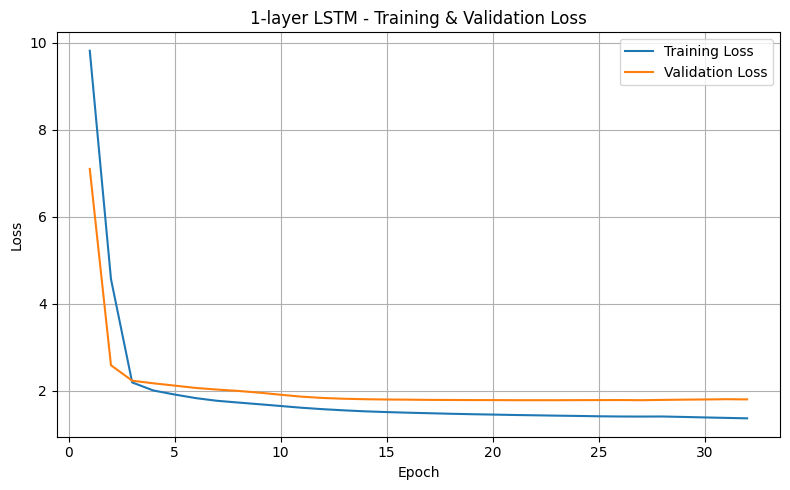

In [49]:
plot_training_history(hist_1layer_dict, '1-layer LSTM')

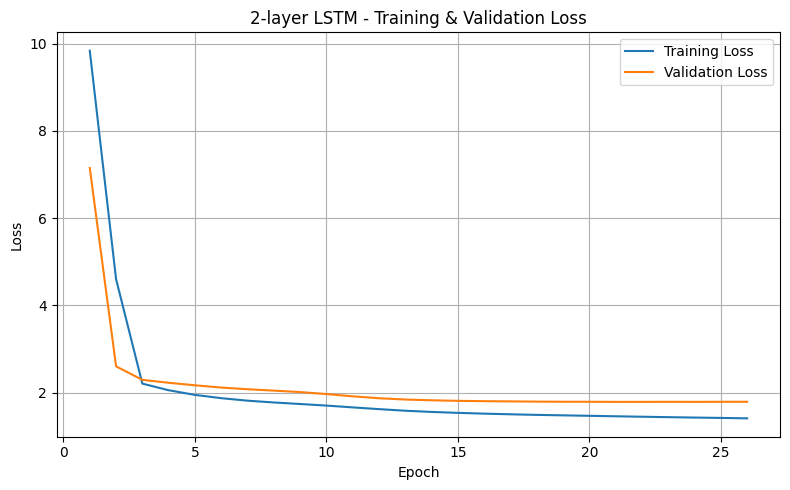

In [50]:
plot_training_history(hist_2layer_dict, '2-layer LSTM')

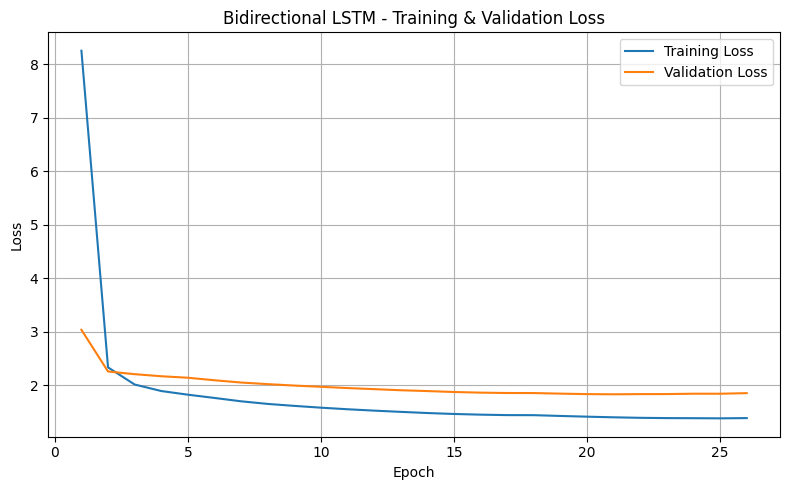

In [51]:
plot_training_history(hist_bilstm_dict, 'Bidirectional LSTM')

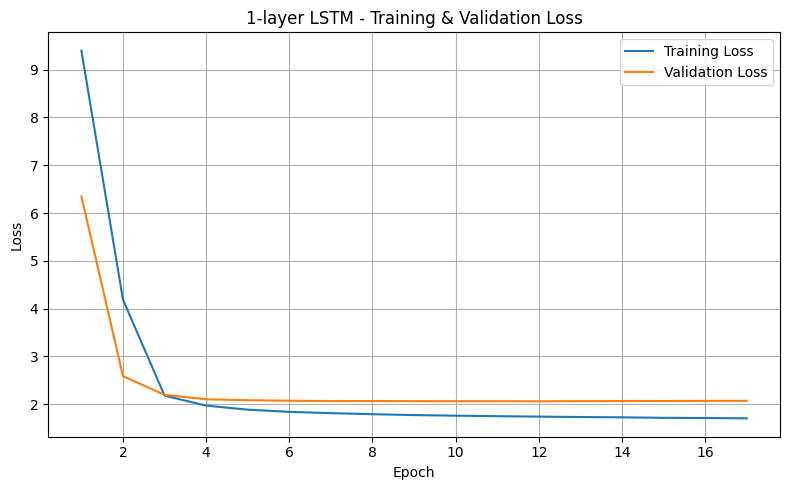

In [52]:
plot_training_history(hist_1layer_attention_dict, '1-layer LSTM')

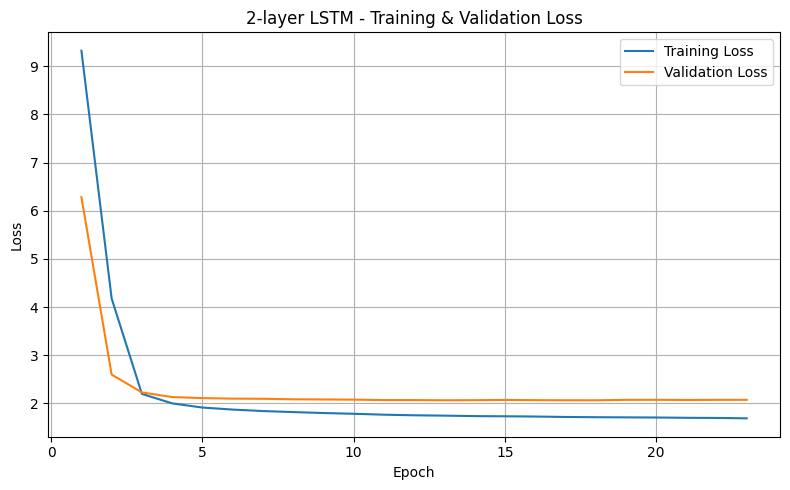

In [53]:
plot_training_history(hist_2layer_attention_dict, '2-layer LSTM')

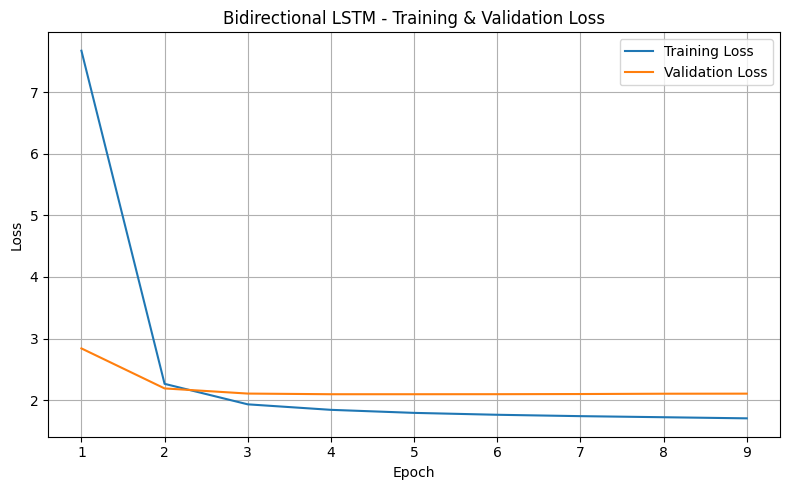

In [54]:
plot_training_history(hist_bilstm_attention_dict, 'Bidirectional LSTM')

In [71]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate
import numpy as np

def load_inference_models(model_path, variant, tokenizer, max_input_len):
    """
    Loads a trained seq2seq model from disk and returns (encoder_model, decoder_model).
    """
    # 1) Load the full trained model
    model = load_model(model_path)

    # 2) Rebuild the encoder inference model
    if variant in ('1-layer','2-layer'):
        # for both 1-layer and 2-layer, the second LSTM layer is named 'encoder_lstm'
        enc_layer = model.get_layer('encoder_lstm')
        # enc_layer.output = [encoder_output, state_h, state_c]
        encoder_model = Model(model.input[0], enc_layer.output[1:])
        lstm_units = enc_layer.units
    else:  # bilstm
        bi = model.get_layer('encoder_bilstm')
        _, f_h, f_c, b_h, b_c = bi.output
        st_h = Concatenate()([f_h, b_h])
        st_c = Concatenate()([f_c, b_c])
        encoder_model = Model(model.input[0], [st_h, st_c])
        lstm_units = bi.forward_layer.units * 2  # since we concatenated

    # 3) Rebuild the decoder inference model
    token_in   = Input(shape=(1,),          name='in_token')
    state_h_in = Input(shape=(lstm_units,), name='in_state_h')
    state_c_in = Input(shape=(lstm_units,), name='in_state_c')

    dec_embed = model.get_layer('decoder_embedding')
    dec_lstm  = model.get_layer('decoder_lstm')
    dec_dense = model.get_layer('decoder_dense')

    x = dec_embed(token_in)                                           # (batch,1,emb)
    x, h, c = dec_lstm(x, initial_state=[state_h_in, state_c_in])     # one step
    output_probs = dec_dense(x)                                       # (batch,1,vocab)

    decoder_model = Model(
        inputs=[token_in, state_h_in, state_c_in],
        outputs=[output_probs, h, c],
        name=f"inference_decoder_{variant}"
    )

    return encoder_model, decoder_model


# Example: load your 1-layer model, then generate a slogan
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
encoder_model, decoder_model = load_inference_models('best_bilstm.keras',
                                             variant='bilstm',
                                             tokenizer=tokenizer,
                                             max_input_len=128)
def top_k_sample(probs, k=10):
            top_k_indices = probs.argsort()[-k:][::-1]  # get indices of top-k tokens
            top_k_probs = probs[top_k_indices]
            top_k_probs /= top_k_probs.sum()           # normalize to get probabilities
            return np.random.choice(top_k_indices, p=top_k_probs)
        
def generate_slogan(desc_text, encoder_model, decoder_model, tokenizer,
                    max_input_len=128, max_target_len=32):
    # encode
    enc_ids = tokenizer(desc_text.lower(),
                        return_tensors='np',
                        padding='max_length',
                        truncation=True,
                        max_length=max_input_len)['input_ids']
    state_h, state_c = encoder_model.predict(enc_ids, verbose=0)

    # decode
    tgt = np.array([[tokenizer.bos_token_id]])
    tokens = []
    for _ in range(max_target_len):
        probs, state_h, state_c = decoder_model.predict(
            [tgt, state_h, state_c], verbose=0
        )
        probs_new = probs[0, 0]
        # next_id = np.argmax(probs[0, -1, :])
        next_id = top_k_sample(probs_new, k=10)
        if next_id == tokenizer.eos_token_id:
            break
        tokens.append(next_id)
        tgt = np.array([[next_id]])

    return tokenizer.decode(tokens, skip_special_tokens=True)

In [72]:
encoder_model, decoder_model = load_inference_models("best_bilstm.keras", "bi-lstm", tokenizer, max_input_len = 32)

In [73]:
s = generate_slogan("a strategic partner of the law society, company is a legal accounts, practice management and case management cloud based software solution", 
                    encoder_model, 
                    decoder_model,
                    tokenizer, 
                    max_input_len=128, 
                    max_target_len=32)
print("Slogan:", s)

Slogan:  the the in agency for in and 


In [74]:
# Assuming you’ve already run:
#   encoder_model, decoder_model = load_inference_models(...)
#   tokenizer = BartTokenizer.from_pretrained(...)
#   and defined generate_slogan(desc, encoder_model, decoder_model, tokenizer)

exes = [
    ["Easily deliver personalized activities that enrich the lives of residents in older adult communities. Save time and increase satisfaction.",
     "Build World-Class Recreation Programs"],
    ["Powerful lead generation software that converts abandoning visitors into subscribers with our dynamic marketing tools and Exit Intent® technology.",
     "Most Powerful Lead Generation Software for Marketers"],
    ["Twine matches companies to the best digital and creative freelancers from a network of over 260,000. It's free to post a job and you only pay when you hire.",
     "Hire quality freelancers for your job"],
    ["Looking for fresh web design & development? Need new marketing materials or a smart campaign to drive business? How about a video or updated photos? Let's talk and tell the world your story.",
     "Ohio Marketing, Web Design & Development"],
    ['Our expert team of Analytical Chemists provide eLiquid analysis & manufacturing services, ensuring full regulatory compliance for the e-cigarette market.',
    'E-Liquid Testing UK'],
    ['From placing entire software engineering teams to integrating easily into your current team, we offer bespoke placements of the very best engineers.',
    'Software Development Consultancy London'],
    ['Turning ideas into visual content since 1999. Content Creation Studio in Ghent. Branded content - corporate video - visuals for events - 360 video',
    'The Image Distillery'],
    ['World market leader for robotic vision systems, inline measurement technology & inspection technology. We are your partner at over 25 locations worldwide.',
    'Leading Machine Vision Systems'],
    # --- other examples
    ['People and projects for sustainable change. Experts in sustainability recruitment, we recruit exceptional people into roles working on sustainability projects or in ethical and responsible organisations.',
     'Change Agents UK']
    ]

for idx, (desc, reference) in enumerate(exes, 1):
    generated = generate_slogan(desc, encoder_model, decoder_model, tokenizer,
                                max_input_len=128, max_target_len=32)
    print(f"--- Example {idx} ---")
    print(f"Input:     {desc}")
    print(f"Reference: {reference}")
    print(f"Generated: {generated}\n")

--- Example 1 ---
Input:     Easily deliver personalized activities that enrich the lives of residents in older adult communities. Save time and increase satisfaction.
Reference: Build World-Class Recreation Programs
Generated:  your and in and and of agency 

--- Example 2 ---
Input:     Powerful lead generation software that converts abandoning visitors into subscribers with our dynamic marketing tools and Exit Intent® technology.
Reference: Most Powerful Lead Generation Software for Marketers
Generated:  your a for in in and, to and and 

--- Example 3 ---
Input:     Twine matches companies to the best digital and creative freelancers from a network of over 260,000. It's free to post a job and you only pay when you hire.
Reference: Hire quality freelancers for your job
Generated:  the for 

--- Example 4 ---
Input:     Looking for fresh web design & development? Need new marketing materials or a smart campaign to drive business? How about a video or updated photos? Let's talk and te